In [ ]:
# %pip install tqdm

In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, BatchNormalization, Activation, Input, Dense, Flatten, Dropout, Concatenate
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC

import numpy as np
from tqdm import tqdm

import pickle


import os

# Configuration

In [14]:
data_path = '../data/MIT-BIH/'
minute_input_arr = 15 #fix 15 min lun đừng đổi chỗ này
minute_input = 10
minute_output = 10
window_input_arr= 40*minute_input_arr
window_input= 40*minute_input
window_out= 40*minute_output
train_size = 0.8
test_size = 1 - train_size
data_set = {
  0: "test",
  1: "train"
}

# data_set = {
#   0: "test_ram",
#   1: "train_ram"
# }

# length_ecg là độ dài 2 khoảng RR được fixed lúc tiền xử lý dữ liệu 
# (độ dài một dòng trong file excel, trừ cột cuối là nhãn lớp bệnh tim)
length_ecg = 187 
batch_size = 16
model_cls = "LSTM"
'''
Độ dài của input/output càng dài thì số lượng file không đáp ứng đủ để tạo một mẫu hợp lệ 
cho mô hình càng nhiều. Để đám bảo tính thống nhất nên sẽ dùng độ dài dài nhất của phần 
input/output trong quá trình thực nghiệm để là chuẩn từ đó loại các file bị thiếu này đều
ở những phần thực nghiệm input/output khác.
'''
missing_file_train = ['201_V1.csv', '102_V2.csv', '124_V4.csv', '112_V1.csv', '203_V1.csv', '116_V1.csv', '108_V1.csv', '207_V1.csv', '111_V1.csv', '200_V1.csv', '207_MLII.csv', '210_V1.csv', '202_V1.csv', '113_V1.csv', '214_V1.csv', '121_V1.csv', '109_V1.csv', '105_V1.csv', '107_V1.csv', '115_V1.csv', '208_V1.csv']
missing_file_use_arrfeature = ['108_MLII.csv', '212_V1.csv']
missing_file_test = ['213_V1.csv', '231_V1.csv', '228_V1.csv', '222_V1.csv', '232_V1.csv']

# Training New CLS Approach

## Get data

In [50]:
def get_data(istrainset):    
    missing_file = []
    total_sample = 0
    directory = f"{data_path}{data_set[istrainset]}/"
    X_arr, X, y = [], [], []
    for filename in os.listdir(directory):
        if (filename not in (missing_file_train)) and (filename not in (missing_file_test)) and (filename not in (missing_file_use_arrfeature)) and (filename != ".DS_Store"):
            f = os.path.join(directory, filename)
            if os.path.isfile(f):
                df = pd.read_csv(f, header=None)
                data=df.drop(columns=length_ecg) #ECG
                data=data.values
                data1=df.iloc[:, length_ecg] #ARR
                # Số lượng lặp qua dữ liệu
                # num_samples = len(data) - window_input - 1 - window_out
                num_samples = len(data) - window_input_arr - 1 - window_out
                # Tạo dữ liệu train từ cửa sổ trượt
                if num_samples > 0:
                    total_sample = total_sample + num_samples
                    for i in range(num_samples):

                        # X_window = data[i:i+window_input]
                        # y_value = data1[i+window_input+window_out]

                        X_window_arr = np.array(data1[i:i+window_input_arr]).reshape(window_input_arr,1)
                        X_window = data[i+(window_input_arr-window_input):i+window_input_arr]

                        y_value = data1[i+window_input_arr+window_out]

                        # print("-----🐰-----")
                        # print(X_window_arr.shape)
                        # print(X_window.shape)
                        # print("------------")
                        X_arr.append(X_window_arr)
                        X.append(X_window)
                        y.append(y_value)
                else:
                    missing_file.append(filename)
    print("------🍒------")
    print(f"Num of file in {data_set[istrainset]} set can not use due to its missing of length: {len(missing_file)}")
    print(f"Number of sample: {len(y)}/{len(X)}/{total_sample}")
    print(f"Missing files: {missing_file}")
    return X,X_arr,y
   

In [51]:
# # Lấy tập train/test
X_train_ECG, X_train_arr, y_train = get_data(1)
X_test_ECG, X_test_arr, y_test = get_data(0)

------🍒------
Num of file in train set can not use due to its missing of length: 0
Number of sample: 58329/58329/58329
Missing files: []
------🍒------
Num of file in test set can not use due to its missing of length: 0
Number of sample: 16782/16782/16782
Missing files: []


In [58]:
X_train_ECG, X_train_arr, y_train = get_data(1)
X_test_ECG, X_test_arr, y_test = get_data(0)

------🍒------
Num of file in train set can not use due to its missing of length: 0
Number of sample: 58329/58329/58329
Missing files: []
------🍒------
Num of file in test set can not use due to its missing of length: 0
Number of sample: 16782/16782/16782
Missing files: []


In [60]:
print(X_train_ECG[0].shape)
print(X_train_arr[0].shape)

(400, 187)
(600, 1)


## Build Model

In [65]:
def residual_block(x, filters, kernel_size=3, dilation_rate=1):
    # Convolutional block with batch normalization and ReLU activation
    x_res = Conv1D(filters, kernel_size, dilation_rate=dilation_rate, padding='same')(x)
    x_res = BatchNormalization()(x_res)
    x_res = Activation('relu')(x_res)

    # Residual connection
    x_res = Conv1D(filters, kernel_size, dilation_rate=dilation_rate, padding='same')(x_res)
    x_res = BatchNormalization()(x_res)
    x_res = Activation('relu')(x_res)

    x = tf.keras.layers.Add()([x, x_res])
    return x

In [54]:
# def first_branch_extract_ecg():
#     inputs = Input(shape=(window_input, length_ecg))

#     # Convolutional block
#     x = Conv1D(64, kernel_size=3, padding='same')(inputs)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)

#     # Residual blocks
#     for _ in range(3):  # You can adjust the number of residual blocks
#         x = residual_block(x, filters=64, kernel_size=3)

#     # Global average pooling
#     x = tf.keras.layers.GlobalAveragePooling1D()(x)

#     x = Flatten()(x)
#     return x

In [53]:
# def second_branch_extract_arrhythmia(model_name):
#     if model_name == "CNN":
#         inputs = Input(shape=(window_input_arr,1))

#         # Convolutional block
#         x = Conv1D(64, kernel_size=3, padding='same')(inputs)
#         x = BatchNormalization()(x)
#         x = Activation('relu')(x)

#         # Residual blocks
#         for _ in range(3):  # You can adjust the number of residual blocks
#             x = residual_block(x, filters=64, kernel_size=3)

#         # Global average pooling
#         x = tf.keras.layers.GlobalAveragePooling1D()(x)

#         x = Flatten()(x)
#     elif model_name == "LSTM":
#         input_layer = Input(shape=(window_input, length_ecg))
#         x = LSTM(64, activation='relu', return_sequences=True)(input_layer)
#         x = Dropout(0.2)(x)
#         x = LSTM(64, activation='relu', return_sequences=True)(x)
#         x = Dropout(0.2)(x)
#         x = LSTM(64, activation='relu')(x)
#         x = Dropout(0.2)(x)
#         x = Flatten()(x)
#     return x

In [66]:
def build_model_cls(model_name_arrbranch):
    # First extract ECG branch
    x_first_branch_input = Input(shape=(window_input, length_ecg))
    # Convolutional block
    x_first_branch = Conv1D(64, kernel_size=3, padding='same')(x_first_branch_input)
    x_first_branch = BatchNormalization()(x_first_branch)
    x_first_branch = Activation('relu')(x_first_branch)
    # Residual blocks
    for _ in range(3):  # You can adjust the number of residual blocks
        x_first_branch = residual_block(x_first_branch, filters=64, kernel_size=3)
    # Global average pooling
    x_first_branch = tf.keras.layers.GlobalAveragePooling1D()(x_first_branch)
    x_first_branch = Flatten()(x_first_branch)
    x_first_branch = tf.keras.Model(inputs=x_first_branch_input, outputs=x_first_branch)

    # Second extract Arrhythmia branch
    if model_name_arrbranch == "LSTM":
        x_second_branch_input = Input(shape=(window_input_arr,1))
        x_second_branch = LSTM(64, activation='relu', return_sequences=True)(x_second_branch_input)
        x_second_branch = Dropout(0.2)(x_second_branch)
        x_second_branch = LSTM(64, activation='relu', return_sequences=True)(x_second_branch)
        x_second_branch = Dropout(0.2)(x_second_branch)
        x_second_branch = LSTM(64, activation='relu')(x_second_branch)
        x_second_branch = Dropout(0.2)(x_second_branch)
        x_second_branch = Flatten()(x_second_branch)
        x_second_branch = tf.keras.Model(inputs=x_second_branch_input, outputs=x_second_branch)
    if model_name_arrbranch == "CNN":
        x_second_branch_input = Input(shape=(window_input_arr,1))

        # Convolutional block
        x_second_branch = Conv1D(64, kernel_size=3, padding='same')(x_second_branch_input)
        x_second_branch = BatchNormalization()(x_second_branch)
        x_second_branch = Activation('relu')(x_second_branch)
        # Residual blocks
        for _ in range(3):  # You can adjust the number of residual blocks
            x_second_branch = residual_block(x_second_branch, filters=64, kernel_size=3)
        # Global average pooling
        x_second_branch = tf.keras.layers.GlobalAveragePooling1D()(x_second_branch)
        x_second_branch = Flatten()(x_second_branch)
        x_second_branch = tf.keras.Model(inputs=x_second_branch_input, outputs=x_second_branch)

    concatenated = Concatenate()([x_first_branch.output, x_second_branch.output])
    
    x = Dense(64, activation='relu')(concatenated)
    x = Dense(32, activation='relu')(x)


    # Output layer for regression (linear activation)
    outputs = Dense(5, activation='softmax')(x)

    learning_rate = 0.001
    # Create and compile the model
    model = tf.keras.Model(inputs=[x_first_branch.input,x_second_branch.input], outputs=outputs)
    adam = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)    
    model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

## Training

In [67]:
class CombinedDataset:
    def __init__(self, data1, data2, label):
        self.data1 = data1
        self.data2 = data2
        self.label = label

    def __len__(self):
        return len(self.label)

    def __getitem__(self, i):
        X1 = self.data1[i]
        X2 = self.data2[i]
        y = self.label[i].astype(int)
        return X1, X2, y

class CombinedDataLoader(tf.keras.utils.Sequence):
    def __init__(self, dataset, batch_size, size):
        self.dataset = dataset
        self.batch_size = batch_size
        self.size = size

    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size

        data = [self.dataset[j] for j in range(start, stop)]

        X1_batch = np.stack([sample[0] for sample in data], axis=0)
        X2_batch = np.stack([sample[1] for sample in data], axis=0)
        y_batch = np.array([sample[2] for sample in data])

        return [X1_batch, X2_batch], y_batch

    def __len__(self):
        return self.size // self.batch_size


In [68]:
# Create the combined dataset
combined_train_dataset = CombinedDataset(X_train_ECG, X_train_arr, y_train)
combined_train_loader = CombinedDataLoader(combined_train_dataset, batch_size, len(combined_train_dataset))

# Create the combined dataset
combined_test_dataset = CombinedDataset(X_test_ECG, X_test_arr, y_test)
combined_test_loader = CombinedDataLoader(combined_test_dataset, batch_size, len(combined_test_dataset))

In [87]:
model_name_arrbranch = "CNN" #"LSTM"
epochs = 2
model = build_model_cls(model_name_arrbranch)
# model.summary()

In [ ]:
tf.config.run_functions_eagerly(True)
model.fit(combined_train_loader, validation_data=combined_test_loader,verbose=1, epochs=epochs)
model.save(f"trained/New_Proposed_CNN_{model_name_arrbranch}_PastECG_FutureCls_{minute_input}-mininput_{minute_output}-minoutput.h5")


In [72]:
loaded_model = tf.keras.models.load_model(f"trained/New_Proposed_CNN_{model_name_arrbranch}_PastECG_FutureCls_{minute_input}-mininput_{minute_output}-minoutput.h5")
predictions = loaded_model.predict(combined_test_loader)

1048/1048 [==============================] - 31s 29ms/step


In [85]:
y_pred_all = np.argmax(predictions, axis=1)
len(y_pred_all)

16768

In [84]:
y_test = np.array([])
for batch_index in range(len(combined_test_loader)):
    y_test_batch = combined_test_loader[batch_index][1]
    y_test = np.append(y_test, y_test_batch, axis=0)
len(y_test)

16768

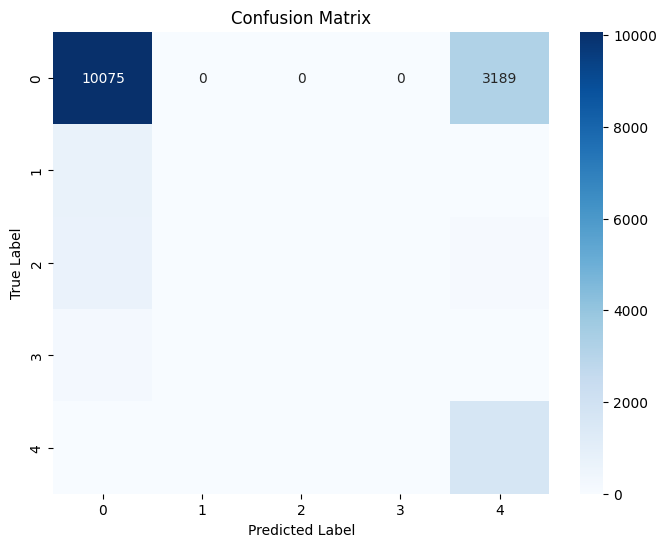

In [86]:
conf_matrix = confusion_matrix(y_test, y_pred_all)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()